In [1]:
import numpy as np
from scipy.fftpack import fftn,  ifftn, ifftshift
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from datetime import datetime
from math import ceil
from skimage.transform import resize


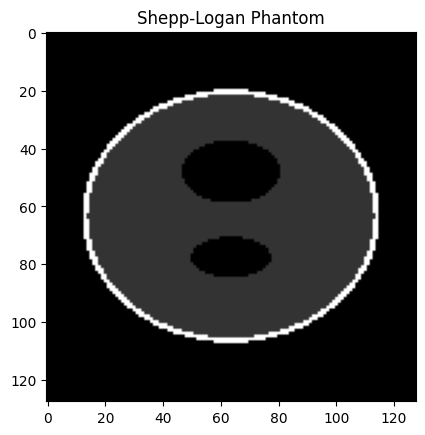

In [2]:
def phantom3d(*args):
    ellipse, n = parse_inputs(*args)
    p = np.zeros((n, n, n))
    rng = np.linspace(-1, 1, n)
    x, y, z = np.meshgrid(rng, rng, rng)
    coord = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    p = p.flatten()
    for k in range(ellipse.shape[0]):
        A = ellipse[k, 0]            # Amplitude change for this ellipsoid
        asq = ellipse[k, 1] ** 2     # a^2
        bsq = ellipse[k, 2] ** 2     # b^2
        csq = ellipse[k, 3] ** 2     # c^2
        x0 = ellipse[k, 4]           # x offset
        y0 = ellipse[k, 5]           # y offset
        z0 = ellipse[k, 6]           # z offset
        phi = ellipse[k, 7] * np.pi / 180   # first Euler angle in radians
        theta = ellipse[k, 8] * np.pi / 180 # second Euler angle in radians
        psi = ellipse[k, 9] * np.pi / 180   # third Euler angle in radians
        cphi = np.cos(phi)
        sphi = np.sin(phi)
        ctheta = np.cos(theta)
        stheta = np.sin(theta)
        cpsi = np.cos(psi)
        spsi = np.sin(psi)
        # Euler rotation matrix
        alpha = np.array([[cpsi * cphi - ctheta * sphi * spsi, cpsi * sphi + ctheta * cphi * spsi, spsi * stheta],
                          [-spsi * cphi - ctheta * sphi * cpsi, -spsi * sphi + ctheta * cphi * cpsi, cpsi * stheta],
                          [stheta * sphi, -stheta * cphi, ctheta]])
        # rotated ellipsoid coordinates
        coordp = np.dot(alpha, coord)
        idx = np.where((coordp[0, :] - x0) ** 2 / asq + (coordp[1, :] - y0) ** 2 / bsq + (coordp[2, :] - z0) ** 2 / csq <= 1)[0]
        p[idx] += A
    p = p.reshape((n, n, n))
    return p, ellipse

def flatten(in_arr):
    return in_arr.flatten()

def parse_inputs(*args):
    n = 128  # Default size
    e = None
    defaults = ['shepp-logan', 'modified shepp-logan', 'yu-ye-wang']
    for i in range(len(args)):
        if isinstance(args[i], str):  # Look for a default phantom
            def_str = args[i].lower()
            idx = defaults.index(def_str) if def_str in defaults else None
            if idx is None:
                raise ValueError('Unknown default phantom selected.')
            if defaults[idx] == 'shepp-logan':
                e = shepp_logan()
            elif defaults[idx] == 'modified shepp-logan':
                e = modified_shepp_logan()
            elif defaults[idx] == 'yu-ye-wang':
                e = yu_ye_wang()
        elif isinstance(args[i], (int, float)):  # a scalar is the image size
            n = int(args[i])
        elif isinstance(args[i], np.ndarray) and args[i].ndim == 2 and args[i].shape[1] == 10:
            e = args[i]  # user specified phantom
        else:
            raise ValueError('Invalid input arguments.')
    if e is None:
        e = modified_shepp_logan()
    return e, n

# Default head phantoms

def shepp_logan():
    return modified_shepp_logan()

def modified_shepp_logan():
    return np.array([[1, 0.6900, 0.920, 0.810, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.780, 0, -0.0184, 0, 0, 0, 0],
                     [-0.2, 0.1100, 0.310, 0.220, 0.22, 0, 0, -18, 0, 10],
                     [-0.2, 0.1600, 0.410, 0.280, -0.22, 0, 0, 18, 0, 10],
                     [0.1, 0.2100, 0.250, 0.410, 0, 0.35, -0.15, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, 0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, -0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.050, -0.08, -0.605, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.023, 0.020, 0, -0.606, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.046, 0.020, 0.06, -0.605, 0, 0, 0, 0]])

def yu_ye_wang():
    return np.array([[1, 0.6900, 0.920, 0.900, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.880, 0, 0, 0, 0, 0, 0],
                     [-0.2, 0.4100, 0.160, 0.210, -0.22, 0, -0.25, 108, 0, 0],
                     [-0.2, 0.3100, 0.110, 0.220, 0.22, 0, -0.25, 72, 0, 0],
                     [0.2, 0.2100, 0.250, 0.500, 0, 0.35, -0.25, 0, 0, 0],
                     [0.2, 0.0460, 0.046, 0.046, 0, 0.1, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, -0.08, -0.65, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, 0.06, -0.65, -0.25, 90, 0, 0],
                     [0.2, 0.0560, 0.040, 0.100, 0.06, -0.105, 0.625, 90, 0, 0],
                     [-0.2, 0.0560, 0.056, 0.100, 0, 0.100, 0.625, 0, 0, 0]])

# Example usage:

# Create a 3D phantom

p, e = phantom3d('shepp-logan', 128)
# Display the 3D phantom
plt.figure()
plt.imshow(p[64, :, :], cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.show()


In [18]:
def make_phantom_5D(SN, RN, DN):
    # Generate 3D phantom data
    P3, _ = phantom3d(RN)

    # Resample the 3D phantom to create a 5D array
    P3RS = np.zeros((SN, DN, RN))

    for i in range(RN):
        P3RS[:, :, i] = np.resize(P3[:,:,i], (SN, DN))

    # Flatten the original 3D phantom
    P3_flat = P3.flatten()

    # Randomly sample from the resampled 3D phantom
    P3RS_m = P3RS[:, :, np.random.randint(RN, size=RN**3)]

    # Transpose the sampled 3D phantom
    P3RS_f = np.transpose(P3RS_m, (2, 0, 1))

    # Create the 5D phantom by element-wise multiplication
    P5 = P3_flat[:, np.newaxis, np.newaxis] * P3RS_f

    # Reshape the 5D phantom
    P5 = np.reshape(P5, (RN, RN, RN, SN, DN))

    # Transpose the dimensions of the 5D phantom
    P5 = np.transpose(P5, (3, 0, 1, 2, 4))

    return P5


In [20]:
# example usage
SN = 16
RN = 48
DN = 8
TN = 20
P5 = make_phantom_5D(SN, RN, DN)

# desciption of the 5D phantom

# print(P5.shape)
# print(P5.dtype)


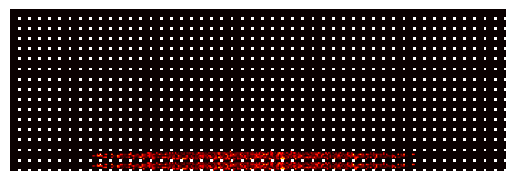

In [21]:
B0 = 3 # T
DW = 4e-6  # 4 us gradient resolution fixed
TN = 8192
AT = DW * TN  # acquisition time in s

plot5d(P5, 1, 3)

In [8]:
def MW_makeG_enc(MW, TN, WN, DW, DP, RN, maxDG, maxG, FOV, Gamma, HzpT):
    # making G matrices for encoding data

    # MW: maximum waveforms
    # TN: time points
    # WN: waveforms
    # DW: dwell time
    # DP: delay points
    # RN: row number
    # maxDG: maximum gradient
    # maxG: maximum slew rate
    # FOV: field of view
    # Gamma: gyromagnetic ratio
    # HzpT: Hz per Tesla

    G = np.zeros((TN, WN))

    PSN = np.ceil(np.sqrt(RN / FOV / Gamma / maxDG / (DW ** 2) / 0.3 * 6))
    minG = min(maxDG * DW / (6 / PSN), maxG)

    DBND = 6 * PSN
    CBND = 0.3 / PSN

    for _ in range(5):
        PSN = np.ceil(np.sqrt(RN / FOV / Gamma / maxDG / (DW ** 2) / CBND * DBND))
        minG = min(maxDG * DW / (DBND / PSN), maxG)

        Tlen = int(PSN / 2)

        SymT1 = np.linspace(-1, 1, Tlen)
        SymT2 = np.linspace(1, -1, Tlen)[1:]
        GS = np.concatenate((np.sinc(SymT1), -np.sinc(SymT2), [0]))
        GW = np.diff(GS)
        CG = np.cumsum(GS)

        DBND = np.max(np.abs(GW)) * PSN
        CBND = np.max(np.abs(CG)) / PSN

    print('Minimum paired sinc length =', PSN, 'for maxG-DG =', maxG, '-', maxDG)

    Plen = DP
    PMW = int(np.floor((TN - Plen) / PSN))
    print('Maximum waveforms =', PMW, ', requested =', MW)

    for wi in range(WN):
        MM = np.random.randint(1, min(PMW, MW) + 1)

        Tlen = int((TN - Plen) / MM / 2)

        SymT1 = np.linspace(-1, 1, Tlen)
        SymT2 = np.linspace(1, -1, Tlen)[1:]

        GS = np.concatenate((np.sinc(SymT1), -np.sinc(SymT2), [0]))

        for mi in range(1, MM):
            start_idx = (mi - 1) * 2 * Tlen + 1 + Plen
            end_idx = min((mi * 2 * Tlen + Plen), TN)
            if end_idx - start_idx != len(GS):
                end_idx = start_idx + len(GS)  # Adjusted line
            G[start_idx:end_idx, wi] = (-1) ** np.random.randint(2, size=1) * GS

        CG = np.cumsum(G[:, wi])
        scaleG = (RN - 1) / (FOV * Gamma * DW * max(abs(CG)) + np.finfo(float).eps)
        G[:, wi] = scaleG * G[:, wi]

    G[0, :] = 0
    G[-1, :] = 0

    GW = np.diff(G, axis=0)
    KG = DW * np.cumsum(G, axis=0) * FOV * Gamma + 1
    print('K-space reachable =', np.max(KG))
    print('mean/max slew rate =', np.mean(np.abs(GW) / DW / HzpT), np.max(np.abs(GW) / DW / HzpT))
    print('% of max slew rate =', np.max(np.abs(GW)) / maxDG / DW * 100)

    return G


# Example usage:

# Create a 5D k-space trajectory

TN = 256  # Time
WN = 16  # Waveform
DW = 0.004  # Dwell time
DP = 16  # Delay
RN = 64  # Row
maxDG = 0.04  # Maximum gradient
maxG = 0.04  # Maximum slew rate
FOV = 0.2  # Field of view

Gamma = 42.58e6  # Gyromagnetic ratio
HzpT = 1e-4  # Hz per Tesla

# G = MW_makeG_enc(1, TN, WN, DW, DP, RN, maxDG, maxG, FOV, Gamma, HzpT)

In [9]:
def enc_summary(TN, RN, DW, FOV, maxG):
    # Summary of encoding stats for given TN and DW over FOV compared to system maxG

    # Acquisition time
    AT = TN * DW

    # Nominal required gradient strength in Hz / m
    G = (RN - 1) / FOV / AT

    # Encoding summary
    print(f"Encoding FOV = {FOV} m, with {RN} points, resolution = {FOV/RN*1e3:.2f} mm")
    print(f"Acquisition Time = {AT} s with {TN} points, dwell time = {AT/TN * 1e6:.2f} us")
    print(f"Requires G = {G:.2f} Hz/m, {1e2*G/maxG:.2e} % of max G = {maxG} Hz/m")



# Example usage:
TN = 10
RN = 64
DW = 1
FOV = 1
maxG = 1

# enc_summary(TN, RN, DW, FOV, maxG)


In [10]:
def make_Kspace(u, cgrad, FOV, SN, RN, DN, Gamma):
    # Vectorize cgrad time x waves
    TN, WN, _ = cgrad.shape
    cgrad = cgrad.reshape(TN * WN, 3)

    # Kronecker product
    spect = np.kron(np.round(np.linspace(1, SN, TN)), np.ones(WN))

    # partie entière inférieur de chaque élément du tableau
    space = np.floor(-cgrad * FOV / 2 * Gamma + RN / 2 + 1)

    dynmx = np.kron(np.round(np.linspace(1, DN, TN)), np.ones(WN))

    # crée une matrice à partir de trois vecteurs colonnes
    kgrad = np.column_stack((spect, space, dynmx))

    # Set the K array
    C, _, IC = np.unique(kgrad, axis=0, return_index=True, return_inverse=True)
    Ksize = [SN, RN, RN, RN, DN]
    M = np.zeros(Ksize)

    IC = kgrad

    print('shape of kgrad:', kgrad.shape)
    # Weight by obs - need noise estimate factor
    macc = np.bincount(IC, minlength=TN * WN) / TN
    print('shape of macc:', macc.shape)
    print('shape of C:', C.shape)
    print('shape of IC:', IC.shape)
    print('shape of M:', M.shape)

    M[np.round(C[:, 0]).astype(int),
      np.round(C[:, 1]).astype(int),
      np.round(C[:, 2]).astype(int),
      np.round(C[:, 3]).astype(int),
      np.round(C[:, 4]).astype(int)] = macc

    M = np.fft.ifftshift(M.reshape(Ksize))

    K = M * np.fft.fftn(u)

    return K, M


In [71]:
# Example usage:

# Create a 5D k-space trajectory
TN = 256  # Time
WN = 16  # Waveform
DW = 0.004  # Dwell time
DP = 16  # Delay
RN = 64  # Row
maxDG = 0.04  # Maximum gradient
maxG = 0.04  # Maximum slew rate
FOV = 0.2  # Field of view


Gamma = 42.58e6  # Gyromagnetic ratio
HzpT = 1e-4  # Hz per Tesla

# Gradients (XY) scale to recon size
enc_grad = np.zeros((TN, WN, 3))
for i in range(3):
    enc_grad[:, :, i] = MW_makeG_enc(16, TN, WN, DW, DP, RN, maxDG, maxG, FOV, Gamma, HzpT)

enc_cgrad = DW * cumtrapz(enc_grad, axis=0)

# Create a 5D phantom
SN = 64  # Slice
RN = 64  # Row
DN = 64  # Column

P5 = make_phantom_5D(SN, RN, DN)

Minimum paired sinc length = 18.0 for maxG-DG = 0.04 - 0.04
Maximum waveforms = 13 , requested = 16
K-space reachable = 64.00000000000001
mean/max slew rate = 65.42499690097509 332.8833369632724
% of max slew rate = 83.22083424081809
Minimum paired sinc length = 18.0 for maxG-DG = 0.04 - 0.04
Maximum waveforms = 13 , requested = 16
K-space reachable = 64.00000000000001
mean/max slew rate = 95.84130860642934 332.8833369632724
% of max slew rate = 83.22083424081809
Minimum paired sinc length = 18.0 for maxG-DG = 0.04 - 0.04
Maximum waveforms = 13 , requested = 16
K-space reachable = 64.00000000000003
mean/max slew rate = 52.112319523761165 332.8833369632724
% of max slew rate = 83.22083424081809
Shape of P3: (64, 64, 64)
Shape of P3RS: (64, 64, 64)
Shape of P3_flat: (262144,)


/var/folders/q3/sl_3k64s2ldb0zk8pjw9qplc0000gn/T/ipykernel_1881/2287158317.py:22: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  enc_cgrad = DW * cumtrapz(enc_grad, axis=0)


Shape of P3RS_m: (64, 64, 262144)
Shape of P3RS_f: (262144, 64, 64)
Shape of P5 (before transpose): (64, 64, 64, 64, 64)
Shape of P5 (after transpose): (64, 64, 64, 64, 64)


In [11]:
# Create a 5D k-space trajectory
K, M = make_Kspace(P5, enc_cgrad, FOV, SN, RN, DN, Gamma)

# Display the 5D k-space trajectory
plt.figure()
plt.imshow(K[32, 32, :, :, 32], cmap='gray')
plt.title('5D k-space trajectory')
plt.show()

NameError: name 'enc_cgrad' is not defined

In [12]:
def sbtv1_4D(R, d, mu, la, bout, stats=False):
    # Initialize variables
    sized = d.shape
    fu = d.copy()

    # Bregman variables
    alpha = np.zeros(sized)
    u = np.zeros(sized)
    s = np.zeros(sized)
    x = np.zeros(sized)
    y = np.zeros(sized)
    z = np.zeros(sized)

    # Laplace
    L = np.zeros(sized)
    L[1,0,0,0] = -1
    L[-1,0,0,0] = -1
    L[0,0,0,0] += 2
    L[0,1,0,0] = -1
    L[0,-1,0,0] = -1
    L[0,0,0,0] += 2
    L[0,0,1,0] = -1
    L[0,0,-1,0] = -1
    L[0,0,0,0] += 2
    L[0,0,0,1] = -1
    L[0,0,0,-1] = -1
    L[0,0,0,0] += 2



    LFT = fftn(L)

    # Scale mu and la by approximate norm of differential operator
    ns = 2
    la0 = la
    mu = mu / la0 * ns
    la = la / la0 * ns
    ila = 1. / la

    # FFT scale and denominator
    scale = d.size
    muscR = mu * scale * np.conj(R)
    muscRd = muscR * d
    dom = muscR * R + la * LFT

    # Invert and suppress small values
    pinvdom = 1. / dom
    ptol = scale * np.finfo(float).eps * np.max(np.abs(dom))
    pinvdom[np.abs(dom) < ptol] = 0

    # Run stats
    if stats:
        iter = 1
        obj = np.zeros((bout - 1, 5))

    # Do the reconstruction
    for bo in range(bout - 1):
        fu = pinvdom * (muscRd - la * fftn(np.diff(np.pad(s * alpha, [(1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0), 1, 0)
                                    - la * fftn(np.diff(np.pad(x * alpha, [(0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=1), 1, 1)
                                    - la * fftn(np.diff(np.pad(y * alpha, [(0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=2), 1, 2)
                                    - la * fftn(np.diff(np.pad(z * alpha, [(0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=3), 1, 3))

        u = ifftn(fu)

        alpha = (alpha + 1) / 2

        s = s * alpha - np.diff(np.pad(u, [(1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0)
        x = x * alpha - np.diff(np.pad(u, [(0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=1)
        y = y * alpha - np.diff(np.pad(u, [(0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=2)
        z = z * alpha - np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=3)

        alpha = np.abs(s) + np.abs(x) + np.abs(y) + np.abs(z)
        alpha[alpha < ila] = ila
        alpha = (2 * ila / alpha) - 1

        if stats:
            ds = np.diff(np.pad(u, [(1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0)
            dx = np.diff(np.pad(u, [(0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=1)
            dy = np.diff(np.pad(u, [(0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=2)
            dz = np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=3)

            obj_f = d - (R * fu)
            obj[iter - 1, 0] = np.linalg.norm(obj_f[obj_f != 0], 2)
            obj[iter - 1, 1] = np.linalg.norm(ds, 1)
            obj[iter - 1, 2] = np.linalg.norm(dx, 1)
            obj[iter - 1, 3] = np.linalg.norm(dy, 1)
            obj[iter - 1, 4] = np.linalg.norm(dz, 1)

            iter += 1

    u = ifftn(pinvdom * (muscRd - la * fftn(np.diff(np.pad(s * alpha, [(1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0), 1, 0)
                                     - la * fftn(np.diff(np.pad(x * alpha, [(0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=1), 1, 1)
                                     - la * fftn(np.diff(np.pad(y * alpha, [(0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=2), 1, 2)
                                     - la * fftn(np.diff(np.pad(z * alpha, [(0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=3), 1, 3)))

    if stats:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.title('Run stats - L1')
        rr = 1
        cc = 2
        plt.subplot(rr, cc, 1)
        plt.plot(obj[:, 0])
        plt.title('L2 objective')
        plt.subplot(rr, cc, 2)
        plt.plot(obj[:, 1:])
        plt.title('Lp gradients')
        plt.show()

    return u


In [13]:
def sbtv1_5D(R, d, mu, la, bout, stats=False):
    # Initialize variables
    sized = d.shape
    if stats:
        fu = d.copy()

    # Bregman variables
    alpha = np.zeros(sized)
    u = np.zeros(sized)
    s = np.zeros(sized)
    x = np.zeros(sized)
    y = np.zeros(sized)
    z = np.zeros(sized)
    t = np.zeros(sized)

    # Laplace
    L = np.zeros(sized)
    L[1,0,0,0,0] = -1
    L[-1,0,0,0,0] = -1
    L[0,0,0,0,0] += 2
    L[0,1,0,0,0] = -1
    L[0,-1,0,0,0] = -1
    L[0,0,0,0,0] += 2
    L[0,0,1,0,0] = -1
    L[0,0,-1,0,0] = -1
    L[0,0,0,0,0] += 2
    L[0,0,0,1,0] = -1
    L[0,0,0,-1,0] = -1
    L[0,0,0,0,0] += 2
    L[0,0,0,0,1] = -1
    L[0,0,0,0,-1] = -1
    L[0,0,0,0,0] += 2

    LFT = fftn(L)

    # Scale mu and la by approximate norm of differential operator
    ns = 4
    la0 = la
    mu = mu / la0 * ns
    la = la / la0 * ns
    ila = 1. / la

    # FFT scale and denominator
    scale = d.size
    muscR = mu * scale * np.conj(R)
    muscRd = muscR * d
    dom = muscR * R + la * LFT

    # Invert and suppress small values
    pinvdom = 1. / dom
    ptol = scale * np.finfo(float).eps * np.max(np.abs(dom))
    pinvdom[np.abs(dom) < ptol] = 0

    # Run stats
    if stats:
        iter = 1
        obj = np.zeros((bout - 1, 6))

    # Do the reconstruction
    for bo in range(bout - 1):
        if stats:
            print(f"Iteration {bo + 1} of {bout}")
        u = ifftn(pinvdom * (muscRd - la * fftn(np.diff(np.pad(s * alpha, [(1, 0), (0, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0), 1, 0)
                                    - la * fftn(np.diff(np.pad(x * alpha, [(0, 0), (1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=1), 1, 1)
                                    - la * fftn(np.diff(np.pad(y * alpha, [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=2), 1, 2)
                                    - la * fftn(np.diff(np.pad(z * alpha, [(0, 0), (0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=3), 1, 3)
                                    - la * fftn(np.diff(np.pad(t * alpha, [(0, 0), (0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=4), 1, 4)))

        alpha = (alpha + 1) / 2

        s = s * alpha - np.diff(np.pad(u, [(1, 0), (0, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0)
        x = x * alpha - np.diff(np.pad(u, [(0, 0), (1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=1)
        y = y * alpha - np.diff(np.pad(u, [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=2)
        z = z * alpha - np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=3)
        t = t * alpha - np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=4)

        alpha = np.abs(s) + np.abs(x) + np.abs(y) + np.abs(z) + np.abs(t)
        alpha[alpha < ila] = ila
        alpha = 2 * ila / alpha - 1

        # Stats
        if stats:
            ds = np.diff(np.pad(u, [(1, 0), (0, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0)
            dx = np.diff(np.pad(u, [(0, 0), (1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=1)
            dy = np.diff(np.pad(u, [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=2)
            dz = np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=3)
            dt = np.diff(np.pad(u, [(0, 0), (0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=4)

            obj_f = d - (R * fftn(u))
            obj[iter - 1, 0] = np.linalg.norm(obj_f[obj_f != 0], 2)
            obj[iter - 1, 1] = np.linalg.norm(ds, 1)
            obj[iter - 1, 2] = np.linalg.norm(dx, 1)
            obj[iter - 1, 3] = np.linalg.norm(dy, 1)
            obj[iter - 1, 4] = np.linalg.norm(dz, 1)
            obj[iter - 1, 5] = np.linalg.norm(dt, 1)

            iter += 1

    u = ifftn(pinvdom * (muscRd - la * fftn(np.diff(np.pad(s * alpha, [(1, 0), (0, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=0), 1, 0)
                                     - la * fftn(np.diff(np.pad(x * alpha, [(0, 0), (1, 0), (0, 0), (0, 0), (0, 0)], 'circular'), axis=1), 1, 1)
                                     - la * fftn(np.diff(np.pad(y * alpha, [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0)], 'circular'), axis=2), 1, 2)
                                     - la * fftn(np.diff(np.pad(z * alpha, [(0, 0), (0, 0), (0, 0), (1, 0), (0, 0)], 'circular'), axis=3), 1, 3)
                                     - la * fftn(np.diff(np.pad(t * alpha, [(0, 0), (0, 0), (0, 0), (0, 0), (1, 0)], 'circular'), axis=4), 1, 4)))

    if stats:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.title('Run stats - L1')
        rr = 1
        cc = 2
        plt.subplot(rr, cc, 1)
        plt.plot(obj[:, 0])
        plt.title('L2 objective')
        plt.subplot(rr, cc, 2)
        plt.plot(obj[:, 1:])
        plt.title('Lp gradients')
        plt.show()

    return u


In [14]:
def plot5d(u, AT, B0):
    # Calculate frequency axis
    sweep = 1 / (AT / (u.shape[0] / 2)) / 2 / B0
    freqaxis = np.linspace(-sweep / 2, sweep / 2, u.shape[0])

    # Pad xy dimensions
    u = np.pad(u, ((0, 0), (0, 1), (0, 1), (0, 0), (0, 0)), mode='constant', constant_values=0)

    if u.shape[4] < 2:
        u = np.pad(u, ((0, 1), (0, 0), (0, 0), (0, 0), (0, 0)), mode='wrap')

    # Collapse spectral/time dimensions
    m = np.squeeze(np.sum(np.sum(np.abs(u), axis=4), axis=1))

    sx, sy, sz = m.shape
    sqz1 = int(np.ceil(np.sqrt(sz)))
    sqz2 = int(np.round(np.sqrt(sz)))

    p = np.full((sx, sy, sqz1 * sqz2), np.nan)
    p[:, :, :sz] = m
    p = p.reshape((sx, sy, sqz1, sqz2))
    p = np.transpose(p, (0, 2, 1, 3)).reshape((sx * sqz1, sy * sqz2))

    # Plot
    plt.figure()

    plt.imshow(np.abs(p), cmap='hot')
    plt.axis('off')


In [15]:
def poissonDisc(size, radius, num_points, seed):
    # Poisson disc sampling

    # size: size of the grid
    # radius: minimum distance between points
    # num_points: number of points to generate
    # seed: random seed

    np.random.seed(seed)
    r = radius
    R = np.sqrt(num_points) * r
    a = np.sqrt(2) * R
    b = np.sqrt(2) * r
    num_cells = np.ceil(a * b / (np.pi * r ** 2))
    grid_size = np.ceil(a / r)
    grid = np.full((int(grid_size), int(grid_size)), -1)
    active_list = []
    sample_points = []
    x0, y0 = np.random.uniform(0, a), np.random.uniform(0, a)
    grid_x, grid_y = int(x0 // r), int(y0 // r)
    grid[grid_x, grid_y] = 0
    active_list.append((x0, y0))
    sample_points.append((x0, y0))
    while active_list:
        idx = np.random.randint(0, len(active_list))
        x, y = active_list[idx]
        active_list.pop(idx)
        for _ in range(int(num_cells)):
            angle = np.random.uniform(0, 2 * np.pi)
            d = np.random.uniform(r, 2 * r)
            x_new, y_new = x + d * np.cos(angle), y + d * np.sin(angle)
            if 0 <= x_new < a and 0 <= y_new < a:
                grid_x, grid_y = int(x_new // r), int(y_new // r)
                if grid[grid_x, grid_y] == -1:
                    valid = True
                    for i in range(max(0, grid_x - 2), min(int(grid_size), grid_x + 3)):
                        for j in range(max(0, grid_y - 2), min(int(grid_size), grid_y + 3)):
                            if grid[i, j] != -1:
                                dx, dy = x_new - grid[i, j][0], y_new - grid[i, j][1]
                                if dx ** 2 + dy ** 2 < r ** 2:
                                    valid = False
                                    break
                        if not valid:
                            break
                    if valid:
                        active_list.append((x_new, y_new))
                        sample_points.append((x_new, y_new))
                        grid[grid_x, grid_y] = (x_new, y_new)
    return np.array(sample_points)


In [16]:
def write_ak_wav(fname, grad, bw, fov, desc='', n_kpts=None, esp_time=0, esp_dir=0, gdt=4):
    # check parameters
    if not isinstance(bw, (int, float)):
        print('Warning: length(bw) != 1')
    if not isinstance(fov, (int, float)):
        print('Warning: length(fov) != 1')
    if n_kpts is not None:
        if not isinstance(n_kpts, (int, float)):
            print('Warning: length(n_kpts) != 1')
    if not isinstance(desc, str):
        print('Warning: ~isinstance(desc, str)')
    if esp_time < 0:
        print(f'Warning: esp_time ({esp_time}) < 0; setting to 0')
        esp_time = 0
    esp_time = round(esp_time)
    esp_dir = round(esp_dir)
    if esp_dir > 3:
        print(f'Warning: esp_dir ({esp_dir}) > 3')
    if esp_dir < 0:
        print(f'Warning: esp_dir ({esp_dir}) < 0')
    if gdt < 4:
        raise ValueError(f'gdt ({gdt}) < 4 [us]')
    gdt = round(gdt)

    # Fixed Parameters
    grad_type = 0

    # Check trajectory
    if len(grad.shape) == 2:
        if not np.isreal(grad).all():
            grad = np.stack((np.real(grad), np.imag(grad)), axis=-1)
    elif len(grad.shape) != 3:
        raise ValueError('length(grad)')
    if not np.isreal(grad).all():
        raise ValueError('~isreal(grad)')
    if grad.shape[0] < grad.shape[2]:
        print('Warning: size(grad,1) < size(grad,3)')
    if np.any(np.abs(grad[0,:,:]) > 1e-10):
        raise ValueError('grad must start with 0')
    if np.any(np.abs(grad[-1,:,:]) > 1e-10):
        raise ValueError('grad must end with 0')
    if grad.shape[0] % 2 != 0:
        grad = np.concatenate((grad, np.zeros((1, grad.shape[1], grad.shape[2]))), axis=0)

    # Derived Parameters
    grad = grad * 1e2  # [T/m] -> [G/cm]
    gmax = np.max(np.abs(grad))
    smax = np.max(np.abs(np.diff(grad, axis=0))) / (gdt * 1e-3)
    fov = fov * 1e2  # [m] -> [cm]
    kdt = 1e6 / bw  # Sampling time; scalar [us]
    if np.abs(np.round(kdt / 2) * 2 - kdt) > 1e-10:
        print(f'Warning: kdt ({kdt}[us]) must be multiple of 2[us]')
    [gpts, intl, groups] = grad.shape  # [#pts/intl, #intl, #groups]
    if n_kpts is None:
        n_kpts = np.ceil(gpts * gdt / kdt / 32) * 32  # # readout pts
    if n_kpts < 64:
        print(f'Warning: n_kpts ({n_kpts}) < 64; setting n_kpts=64 (fidall minimum)')
        n_kpts = 64
    if np.abs(np.ceil(n_kpts / 32) * 32 - n_kpts) > 1e-10:
        print(f'Warning: n_kpts ({n_kpts}) not multiple of 32; rounding up to {np.ceil(n_kpts / 32) * 32}\n')
        n_kpts = np.ceil(n_kpts / 32) * 32
    if gpts > 32766:
        print(f'Warning: n_gpts ({gpts}) > 32766; exceeding maximum of fidall')
    if intl > 16382:
        print(f'Warning: n_intl ({intl}) > 16382; exceeding maximum of fidall')

    print(f'gmax = {gmax * 10} [mT/m] = {gmax} [G/cm]')
    print(f'smax = {smax * 10} [T/m/s] = {smax} [G/cm/ms]')

    # Create Header Information
    if len(desc) > 256:
        print('Warning: length(desc) > 256 -> truncating')
        desc = desc[:256]
    else:
        desc += ' ' * (256 - len(desc))
    desc = desc[:254] + '\n\f\n'

    # Determine worst (sum-of-squares) sub-waveform for pulsegen on host
    wf4pg = np.zeros(3)  # index to waveform [Gx, Gy, Gz]
    if intl > 1:
        tmp = np.sum(grad ** 2, axis=0)
        for l1 in range(groups):
            sos_val = 0
            for l2 in range(intl):
                if tmp[0, l2, l1] > sos_val * 1.001:
                    sos_val = tmp[0, l2, l1]
                    wf4pg[l1] = l2 - 1
        print(f'Worst trajectories: ak_wf4pg_x={wf4pg[0]}, y={wf4pg[1]}, z={wf4pg[2]}')

    # Header Parameters
    params = np.array([grad_type, fov, intl, round(gmax, 6), gpts, gdt, n_kpts, kdt, 0, esp_time, esp_dir, *wf4pg])
    N_params = len(params)  # # parameters

    # Write Header + Waveforms
    wave = np.round(2 * ((2 ** 14 - 1) / gmax * grad)).astype(np.int16)
    wave[-1, :, :] = 1  # Stop criterion: Last pt. of waveform must be odd (e.g., =1)

    # File IO: Open + Write + Close
    with open(fname, 'wb') as f:
        f.write(desc.encode())
        f.write(np.uint16(gpts).tobytes())
        f.write(np.uint16(groups).tobytes())
        f.write(np.uint16(intl * np.ones(groups)).tobytes())
        f.write(np.uint16(N_params).tobytes())
        f.write(params.tobytes())
        f.write(wave.tobytes())

    # Create some output/feedback for control purposes
    out = {
        'N': {'gpts': gpts, 'kpts': n_kpts, 'groups': groups, 'intl': intl, 'params': N_params},
        'parms': params,
        'wave': wave,
        'gmax': gmax,
        'smax': smax,
        'gdt': gdt,
        'kdt': kdt,
        'grad': grad,
        'bw': bw,
        'fov': fov,
        'desc': desc
    }

    return out


Encoding FOV = 0.48 m, with 48 points, resolution = 10.00 mm
Acquisition Time = 0.032768 s with 8192 points, dwell time = 4.00 us
Requires G = 2988.18 Hz/m, 2.34e-01 % of max G = 1277291.5422 Hz/m
Minimum paired sinc length = 304.0 for maxG-DG = 1277291.5422 - 1277291542.2
Maximum waveforms = 26 , requested = 20
K-space reachable = 47.99999999999546
mean/max slew rate = 4.17841043985568 16.7058568361706
% of max slew rate = 55.686189453902
Minimum paired sinc length = 304.0 for maxG-DG = 1277291.5422 - 1277291542.2
Maximum waveforms = 26 , requested = 20
K-space reachable = 47.99999999999546
mean/max slew rate = 3.602147593805081 16.7058568361706
% of max slew rate = 55.686189453902
Minimum paired sinc length = 304.0 for maxG-DG = 1277291.5422 - 1277291542.2
Maximum waveforms = 26 , requested = 20
K-space reachable = 47.99999999999546
mean/max slew rate = 3.940270637965489 16.7058568361706
% of max slew rate = 55.686189453902


/var/folders/q3/sl_3k64s2ldb0zk8pjw9qplc0000gn/T/ipykernel_23616/2466699259.py:65: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  enc_cgrad = DW * cumtrapz(enc_grad, axis=0)


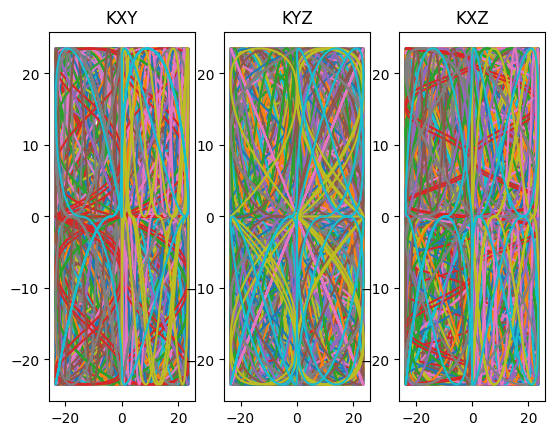

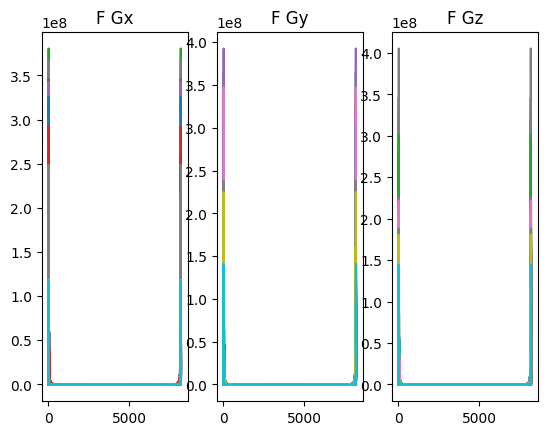

Testing waveforms:
Phantom 5D (SXYZT) ...
SN = 32
RN = 48
DN = 8
Plotting Phantom ...
Putting into k-space
FOV = 0.48
SN = 32
RN = 48
DN = 8
Gamma = 1
Enc_cgrad = (8191, 100, 3)
u = (32, 48, 48, 48, 8)
shape of kgrad: (819100, 5)


ValueError: object too deep for desired array

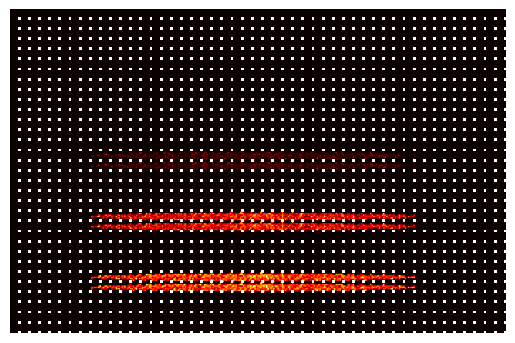

In [23]:
def LFR_waves(TN, WN, MW, SN, RN, DN, FOV, DPnkDW, kDW, maxDG_Tpms, bout, poissonflag, writeflag):
    # inupts:
    # TN: number of gradient points
    # WN: number of waves
    # MW: number of waveforms
    # SN: number of slices
    # RN: number of k-space points
    # DN: number of dimensions
    # FOV: field of view in m
    # DPnkDW: number of points per k-space point
    # kDW: k-space dwell time in s
    # maxDG_Tpms: maximum gradient amplitude in T/m/s
    # bout: number of iterations
    # poissonflag: flag for poisson disc scaling
    # writeflag: flag for writing GE struct

    # Gradient GE 750WB 3T
    B0 = 3.0  # T
    Gamma = 1  # 0.251449530; gyro ratio 13C / 1H from DSS
    HzpT = 42.57638474 * 1e6  # Hz/T Gamma/2pi for 1H in H2O
    Nuc_Hz = B0 * Gamma * HzpT  # Hz : chemical shift evolution in Hz
    maxG_Tpm = 30e-3  # T/m (quote is 50 mT/m) - 30?
    maxG = maxG_Tpm * HzpT  # Hz/m
    maxDG = maxDG_Tpms * HzpT  # Hz/m/s

    # Time
    DW = 4e-6  # 4 us gradient resolution fixed
    AT = DW * TN  # acquisition time in s
    DP = int(np.ceil(DPnkDW * kDW / DW))
    AP = np.arange(DP, TN)  # acquired points - spect must absorb 2tp/pi
    TIME = np.linspace(np.finfo(float).eps, AT, TN)

    # Encoding summary
    enc_summary(TN, RN, DW, FOV, maxG)

    # Gradients (XY) scale to recon size
    enc_grad = np.zeros((TN, WN, 3))
    for i in range(3):
        enc_grad[:, :, i] = MW_makeG_enc(MW, TN, WN, DW, DP, RN, maxDG, maxG, FOV, Gamma, HzpT)

    # Poisson disc scale (-1,1) in steps of 1/WN

    '''

    if poissonflag:
        print('Poisson disc scaling')
        # generate pscale
        pscale = poissonDisc([3, 3, 3], 1 / 100, WN, 0) - 2
        # apply
        enc_grad = np.transpose(pscale * np.transpose(enc_grad, (1, 2, 0)), (1, 2, 0))
        # check slew rate
        GW = np.diff(enc_grad, axis=0)
        print('mean/max slew rate =', np.mean(np.abs(GW) / DW / HzpT), np.max(np.abs(GW) / DW / HzpT))
        print('% of max slew rate =', np.max(np.abs(GW)) / maxDG / DW * 100)


    '''

    # force zero gradients every 256 pulses
    zerograd_idx = np.arange(0, WN, 256)
    enc_grad[zerograd_idx, :, :] = 0


    # encoding cumulative gradients
    enc_cgrad = DW * cumtrapz(enc_grad, axis=0)

    # plot waveforms
    enc_ksps = enc_cgrad * FOV / 2
    fig, axs = plt.subplots(1, 3)
    axs[0].plot(enc_ksps[:, :, 0], enc_ksps[:, :, 1])
    axs[0].set_title('KXY')
    axs[1].plot(enc_ksps[:, :, 1], enc_ksps[:, :, 2])
    axs[1].set_title('KYZ')
    axs[2].plot(enc_ksps[:, :, 0], enc_ksps[:, :, 2])
    axs[2].set_title('KXZ')
    plt.show()

    fig, axs = plt.subplots(1, 3)
    axs[0].plot(np.abs(np.fft.fft(enc_grad[:, :, 0], axis=0)))
    axs[0].set_title('F Gx')
    axs[1].plot(np.abs(np.fft.fft(enc_grad[:, :, 1], axis=0)))
    axs[1].set_title('F Gy')
    axs[2].plot(np.abs(np.fft.fft(enc_grad[:, :, 2], axis=0)))
    axs[2].set_title('F Gz')
    plt.show()

    print('Testing waveforms:')
    print('Phantom 5D (SXYZT) ...')
    # print the arguments of make_phantom_5D

    print('SN =', SN)
    print('RN =', RN)
    print('DN =', DN)

    u = make_phantom_5D(SN, RN, DN)
    # plotting phantom
    print('Plotting Phantom ...')
    plot5d(np.abs(u), AT, B0)
    # k-space
    print('Putting into k-space')
    # printing the arguments of make_Kspace
    print('FOV =', FOV)
    print('SN =', SN)
    print('RN =', RN)
    print('DN =', DN)
    print('Gamma =', Gamma)
    print('Enc_cgrad =', enc_cgrad.shape)
    print('u =', u.shape)
    K, M = make_Kspace(u, enc_cgrad, FOV, SN, RN, DN, Gamma)
    print('Ksize is =', K.shape)
    print('Sparsity is', np.count_nonzero(K) / K.size)
    plot5d(np.abs(np.sign(np.fft.fftshift(M))), AT, B0)
    print('Recon SBTV ... ')
    mu = 1e0
    la = 1e0
    stats = 1
    usb = np.abs(sbtv1_5D(M, K, mu, la, bout, stats))
    plot5d(np.abs(usb), AT, B0)


# Example of usage:
# the mathlab code runs with write_5D_LFRwaves_1H(8192,1000,20,32,48,8,48e-2,1,512e-6,30,30,1,0)

TN = 8192
WN = 1000
MW = 20
SN = 32
RN = 48
DN = 8
FOV = 48e-2
DPnkDW = 1
kDW = 512e-6
maxDG_Tpms = 30
bout = 30
poissonflag = 1
writeflag = 0


LFR_waves(8192, 100, 20, 32, 48, 8, 48e-2, 1, 512e-6, 30, 30, 1, 0)
